In [1]:
import darknet.python.darknet as dn
import glob
import sys
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from src.label import Label, lwrite, Shape, dknet_label_conversion
from src.utils import crop_region, image_files_from_folder, im2single, nms
from src.keras_utils import load_model, detect_lp
from src.drawing_utils import draw_label, draw_losangle, write2img
import math
import cv2
import tempfile
from os.path import splitext, basename, isdir

In [2]:
#!pip install Pillow matplotlib

In [3]:
RED    = (  0,  0,255)
YELLOW = (  0,255,255)


In [4]:
vehicle_threshold = .5

vehicle_weights = 'data/vehicle-detector/yolo-voc.weights'
vehicle_netcfg  = 'data/vehicle-detector/yolo-voc.cfg'
vehicle_dataset = 'data/vehicle-detector/voc.data'

vehicle_net  = dn.load_net(vehicle_netcfg, vehicle_weights, 0)
vehicle_meta = dn.load_meta(vehicle_dataset)

In [5]:
lp_threshold = .5

wpod_net_path = "data/lp-detector/wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [102]:
ocr_threshold = .4

ocr_weights = 'data/ocr/ocr-net.weights'
ocr_netcfg  = 'data/ocr/ocr-net.cfg'

ocr_dataset = 'data/ocr/ocr-net.data'

ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
ocr_meta = dn.load_meta(ocr_dataset)

In [103]:
OUTPUT_DIR = "results/"

In [104]:
imgs = glob.glob("./sample_lbc/*")

In [131]:
img_path = imgs[7]

# DETECT CARS

In [132]:
R,_ = dn.detect(vehicle_net, vehicle_meta, img_path ,thresh=vehicle_threshold)


In [133]:
image_origin = np.array(Image.open(img_path), dtype=np.uint8)

In [134]:
WH = np.array(image_origin.shape[1::-1],dtype=float)
car_list = []
widths = []
heights = []
car_images = []
bname = basename(splitext(img_path)[0])

#TODO : Extract only principal car (with width and height for example) 

In [135]:
for i,r in enumerate(R):
    cx,cy,w,h = (np.array(r[2])/np.concatenate( (WH,WH) )).tolist()
    widths.append(w), heights.append(h)
    tl = np.array([cx - w/2., cy - h/2.])
    br = np.array([cx + w/2., cy + h/2.])
    label = Label(0,tl,br)
    car_image = crop_region(image_origin, label).astype("uint8")
    car_images.append(car_image)
    car_list.append(label)

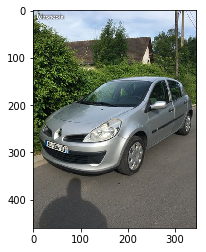

In [136]:
plt.imshow(image_origin)

In [137]:
best_car_image = car_images[np.argmax(widths)]

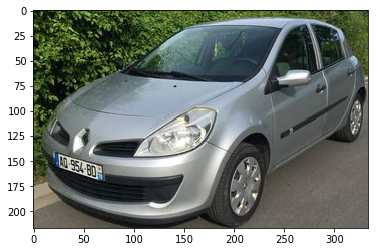

In [138]:
plt.imshow(best_car_image);

In [139]:
ratio = float(max(best_car_image.shape[:2]))/min(best_car_image.shape[:2])
side  = int(ratio*288.)
bound_dim = min(side + (side%(2**4)),608)

In [159]:
best_car_image.shape

(217, 334, 3)

In [160]:
bound_dim

454

In [140]:
Llp,LlpImgs,_ = detect_lp(wpod_net,im2single(best_car_image),bound_dim,2**4,(240,80),lp_threshold)

In [141]:
if len(LlpImgs):
    image_license_plate = LlpImgs[0]
    image_license_plate = cv2.cvtColor(image_license_plate, cv2.COLOR_BGR2GRAY)
    image_license_plate = cv2.cvtColor(image_license_plate, cv2.COLOR_GRAY2BGR)

    s = Shape(Llp[0].pts)
    
else:
    raise Exception("No license plate found")

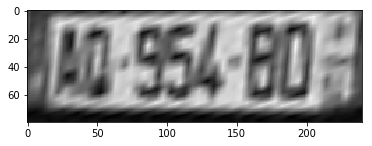

In [142]:
plt.imshow(image_license_plate)

In [143]:
 with tempfile.NamedTemporaryFile(suffix=".png") as temporary_file_name:
        fname = temporary_file_name.name
        cv2.imwrite(str(fname), image_license_plate*255.)
        R,(width,height) = dn.detect(ocr_net, ocr_meta, fname ,thresh=ocr_threshold, nms=None)
        if len(R):
            L = dknet_label_conversion(R,width,height)
            L = nms(L,.45)

            L.sort(key=lambda x: x.tl()[0])
            lp_str = ''.join([chr(l.cl()) for l in L])

In [144]:
lp_str

'D1954B0'

In [145]:
im = Image.open(img_path)

In [146]:
pts = s.pts*car_list[0].wh().reshape(2,1) + car_list[0].tl().reshape(2,1)

In [147]:
ptspx = pts*np.array(np.asarray(im).shape[1::-1],dtype=float).reshape(2,1)

In [148]:
ptspx

array([[ 26.03914202,  73.52368236,  75.34466089,  27.86012056],
       [273.71744256, 288.42022217, 305.09246341, 290.38968379]])

In [149]:
x1 = int(ptspx[0][0])
y1 = int(ptspx[1][0])
x2 = int(ptspx[0][1])
y2 = int(ptspx[1][1])
x3 = int(ptspx[0][2])
y3 = int(ptspx[1][2])
x4 = int(ptspx[0][3])
y4 = int(ptspx[1][3])

height = int(((x1-x2)**2+(y1-y2)**2)**.5)
width = int(((x4-x1)**2 + (y4-y1)**2)**.5)

angle_to_rotate = -math.degrees(math.atan2(y2-y1, x2-x1))
diff = 0 if angle_to_rotate < 0 else int((height**2-(x2-x1)**2)**.5)

In [150]:
im = cv2.imread(img_path)[:, :, ::-1]
im = Image.open(img_path)
icon = Image.open("logo_leboncoin.png").convert('RGBA').resize((height, width))
resized_and_rotate_icon = icon.rotate(angle_to_rotate, expand=1)

In [151]:
icon

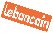

In [152]:
resized_and_rotate_icon

In [153]:
#draw = ImageDraw.Draw(im)
#draw.rectangle(((x1, y1), (x3, y3)), fill="black")
#draw.point((x1, y1), fill="red")
#draw.point((x2, y2), fill="red")
#draw.point((x3, y3), fill="red")
#draw.point((x4, y4), fill="yellow")

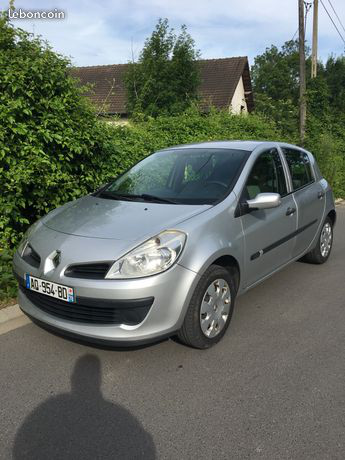

In [154]:
im

In [155]:
diff

0

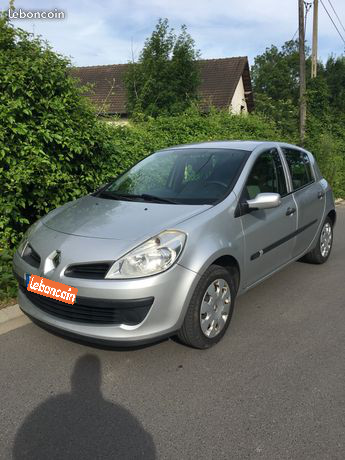

In [156]:
im.paste(resized_and_rotate_icon, (x1, y1-diff), resized_and_rotate_icon)
im